<a href="https://colab.research.google.com/github/Wolffe104-fj/DC25_FinalTask_EchoLab/blob/main/FinalTask_EchoLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Итоговое задание](https://github.com/AsyaOrlova/DataCon25),

by Echo Lab

---

### Скачивание и импортирование библиотек. Подключение Google-диска

---

In [ ]:
!pip install "networkx==2.3" "decorator==4.3.0" "numpy<1.24" mordred[full] rdkit-pypi
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tqdm

!pip install optuna
!pip install catboost

!pip install shap
!pip install meeko rdkit-pypi

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import csv
import time
import urllib.parse
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import joblib

from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from IPython.display import display

import shap
from rdkit.Chem import rdFMCS

import subprocess
from rdkit.Chem.Draw import MolsToGridImage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive подключен")

Mounted at /content/drive
Google Drive подключен


---

### Этап 1. Выбор мишени

---

In [ ]:
'''
Здесь находится информация по выбранным мишеням.
При выборе опирались на актуальность мишени и современные научные статьи, а также:
- открытые данные в достаточном количестве по активности (IC50/Ki) для известных лигандов, связывающихся с мишенью;
- наличие кристаллической структуры белка в Protein Data Bank для возможного учета результатов молекулярного докинга при генерации молекул.
'''

TARGETS_CONFIG = {
    'DRD2': {
        'chembl_id': 'CHEMBL217',
        'activity_types': ['IC50'],
        'units': 'nM',
        'name': 'Dopamine D2 receptor',
        'related_to': 'Neurological disorders',
        'center': [15, 20, 15],
        'size': [20, 20, 20],
        'pdb_id': '6CM4'
    },
    'MAOA': {
        'chembl_id': 'CHEMBL1951',
        'activity_types': ['IC50'],
        'units': 'nM',
        'name': 'Monoamine oxidase A',
        'related_to': 'Neurotransmitter metabolism',
        'center': [10, 15, 10],
        'size': [20, 20, 20],
        'pdb_id': '2Z5X'
    },
    'SERT': {
        'chembl_id': 'CHEMBL228',
        'activity_types': ['Ki'],
        'units': 'nM',
        'name': 'Serotonin transporter',
        'related_to': 'Depression treatment',
        'center': [20, 25, 20],
        'size': [20, 20, 20],
        'pdb_id': '5I6X'
    }
}

print("\nКонфигурация мишеней загружена:")
for target, config in TARGETS_CONFIG.items():
    print(f"- {target}: {config['name']} (ChEMBL:{config['chembl_id']})")


Конфигурация мишеней загружена:
- DRD2: Dopamine D2 receptor (ChEMBL:CHEMBL217)
- MAOA: Monoamine oxidase A (ChEMBL:CHEMBL1951)
- SERT: Serotonin transporter (ChEMBL:CHEMBL228)


---

### Этап 2. Подготовка данных

---

Сбор и сохранение датасета

In [ ]:
def save_data(df, target, activity, step_name, base_path="/content/drive/MyDrive/DataCon2025/all_csv"):
    """Сохранение данных с автоматическим созданием структуры директорий"""

    # Создаем путь вида: base_path/step_name/
    save_dir = os.path.join(base_path, step_name)
    os.makedirs(save_dir, exist_ok=True)

    # Формируем имя файла
    filename = os.path.join(save_dir, f"{target}_{activity}.csv")
    df.to_csv(filename, index=False)
    print(f"Сохранено: {filename} ({len(df)} записей)")
    return filename

In [ ]:
def load_chembl_data(target, activity='Ki', limit=5000):
    """Загрузка и сохранение данных с ChEMBL"""
    print(f"\n{'='*50}")
    print(f"Загрузка данных для {target} ({activity})")

    config = TARGETS_CONFIG[target]
    url = (f"https://www.ebi.ac.uk/chembl/api/data/activity.json?"
           f"target_chembl_id={config['chembl_id']}&"
           f"standard_type={activity}&"
           f"standard_units={config['units']}&"
           f"limit={limit}")

    try:
        print(f"Запрос URL: {url}")  # Для отладки
        response = requests.get(url)
        print(f"Статус ответа: {response.status_code}")  # Для отладки
        data = response.json()
        print(f"Получено записей: {len(data['activities'])}")  # Для отладки

        df = pd.DataFrame(data['activities'])
        print(f"Успешно загружено {len(df)} записей")

        save_data(df, target, activity, "01_raw_data")
        return df
    except Exception as e:
        print(f"Ошибка загрузки: {str(e)}")
        return None

In [ ]:
raw_datasets = {}
for target, config in TARGETS_CONFIG.items():
    for activity in config['activity_types']:
        print(f"\n{'#'*80}")
        print(f"Загрузка данных для {target} ({activity})")

        raw_data = load_chembl_data(target, activity, limit=5000)
        if raw_data is not None:
            raw_datasets[f"{target}_{activity}"] = raw_data
            save_data(raw_data, target, activity, "01_raw_data")


################################################################################
Загрузка данных для DRD2 (IC50)

Загрузка данных для DRD2 (IC50)
Запрос URL: https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id=CHEMBL217&standard_type=IC50&standard_units=nM&limit=5000
Статус ответа: 200
Получено записей: 1000
Успешно загружено 1000 записей
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/01_raw_data/DRD2_IC50.csv (1000 записей)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/01_raw_data/DRD2_IC50.csv (1000 записей)

################################################################################
Загрузка данных для MAOA (IC50)

Загрузка данных для MAOA (IC50)
Запрос URL: https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id=CHEMBL1951&standard_type=IC50&standard_units=nM&limit=5000
Статус ответа: 200
Получено записей: 1000
Успешно загружено 1000 записей
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/01_raw_data/MAOA_IC50.csv (1000 запис

Обработка датасета (пока без дескрипторов)

In [ ]:
def preprocess_dataset(raw_data, target, activity):
    """Предобработка и сохранение данных"""
    print(f"\n{'='*50}")
    print(f"Предобработка данных для {target} ({activity})")

    # 1. Проверка и подготовка данных
    df = raw_data.copy()
    required_cols = ['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'standard_type', 'standard_units']
    df = df[required_cols].dropna()

    # 2. Конвертация активности в nM
    df['activity_nM'] = pd.to_numeric(df['standard_value'], errors='coerce')

    # Конвертация других единиц в nM
    if 'standard_units' in df.columns:
        df.loc[df['standard_units'].str.lower() == 'μm', 'activity_nM'] *= 1000
        df.loc[df['standard_units'].str.lower() == 'mm', 'activity_nM'] *= 1e6

    # 3. Фильтрация валидных значений
    df = df[df['activity_nM'] > 0].dropna()

    # 4. Преобразование в стандартную форму (pIC50/pKi)
    if activity == 'IC50':
        df['pActivity'] = -np.log10(df['activity_nM'] * 1e-9)  # pIC50
    elif activity == 'Ki':
        df['pActivity'] = -np.log10(df['activity_nM'] * 1e-9)  # pKi
    else:
        raise ValueError(f"Unknown activity type: {activity}")

    # 5. Переименование колонок
    result = df.rename(columns={
        'canonical_smiles': 'SMILES',
        'molecule_chembl_id': 'Molecule_ID',
        'standard_value': 'raw_activity',
        'standard_type': 'activity_type',
        'standard_units': 'activity_units'
    })

    print(f"Сохранено молекул: {len(result)} записей")
    print(f"Диапазон pActivity: {result['pActivity'].min():.2f} - {result['pActivity'].max():.2f}")

    # Сохранение обработанных данных
    save_data(result, target, activity, "02_processed")
    return result

In [ ]:
processed_datasets = {}
for (target_activity, raw_data) in raw_datasets.items():
    target, activity = target_activity.split('_')
    print(f"\n{'#'*80}")
    print(f"Предобработка {target} ({activity})")

    processed_data = preprocess_dataset(raw_data, target, activity)
    if processed_data is not None:
        processed_datasets[target_activity] = processed_data
        save_data(processed_data, target, activity, "02_processed")


################################################################################
Предобработка DRD2 (IC50)

Предобработка данных для DRD2 (IC50)
Сохранено молекул: 992 записей
Диапазон pActivity: 3.24 - 18.52
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/02_processed/DRD2_IC50.csv (992 записей)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/02_processed/DRD2_IC50.csv (992 записей)

################################################################################
Предобработка MAOA (IC50)

Предобработка данных для MAOA (IC50)
Сохранено молекул: 999 записей
Диапазон pActivity: 3.00 - 11.31
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/02_processed/MAOA_IC50.csv (999 записей)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/02_processed/MAOA_IC50.csv (999 записей)

################################################################################
Предобработка SERT (Ki)

Предобработка данных для SERT (Ki)
Сохранено молекул: 992 записей
Диапазон pActivity: 2.00 - 

Генерация молекулярных дескрипторов

In [ ]:
def generate_descriptors(df, target, activity):
    """Генерация и сохранение молекулярных дескрипторов (только RDKit)"""
    print(f"\n{'='*50}")
    print(f"Генерация дескрипторов для {target} ({activity})")

    df = df.copy()
    df['Mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if x else None)
    valid_df = df[df['Mol'].notna()].copy()

    print(f"Валидных молекул: {len(valid_df)} из {len(df)}")

    # RDKit Descriptors
    print("\nРасчет RDKit дескрипторов...")
    desc_names = [d[0] for d in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)

    desc_data = []
    for mol in tqdm(valid_df['Mol'], desc="Calculating descriptors"):
        if mol is not None:
            try:
                vals = calc.CalcDescriptors(mol)
                desc_data.append(vals)
            except:
                desc_data.append([np.nan]*len(desc_names))
        else:
            desc_data.append([np.nan]*len(desc_names))

    desc_df = pd.DataFrame(desc_data, columns=desc_names)

    # Объединение результатов
    result = pd.concat([valid_df.reset_index(drop=True), desc_df], axis=1)

    print("\nИтоговые размерности:")
    print(f"• RDKit дескрипторов: {len(desc_df.columns)}")
    print(f"Всего строк: {len(result)}")
    print(f"Колонки после добавления дескрипторов ({len(result.columns)}):")
    print(list(result.columns))

    save_data(result, target, activity, "03_with_features")
    return result

In [ ]:
features_datasets = {}
for (target_activity, processed_data) in processed_datasets.items():
    target, activity = target_activity.split('_')
    print(f"\n{'#'*80}")
    print(f"Генерация дескрипторов для {target} ({activity})")

    features_data = generate_descriptors(processed_data, target, activity)
    if features_data is not None:
        features_datasets[target_activity] = features_data
        save_data(features_data, target, activity, "03_with_features")


################################################################################
Генерация дескрипторов для DRD2 (IC50)

Генерация дескрипторов для DRD2 (IC50)
Валидных молекул: 992 из 992

Расчет RDKit дескрипторов...


Calculating descriptors: 100%|██████████| 992/992 [00:19<00:00, 51.60it/s]



Итоговые размерности:
• RDKit дескрипторов: 217
Всего строк: 992
Колонки после добавления дескрипторов (225):
['Molecule_ID', 'SMILES', 'raw_activity', 'activity_type', 'activity_units', 'activity_nM', 'pActivity', 'Mol', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VS

Calculating descriptors: 100%|██████████| 999/999 [00:11<00:00, 84.48it/s]



Итоговые размерности:
• RDKit дескрипторов: 217
Всего строк: 999
Колонки после добавления дескрипторов (225):
['Molecule_ID', 'SMILES', 'raw_activity', 'activity_type', 'activity_units', 'activity_nM', 'pActivity', 'Mol', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VS

Calculating descriptors: 100%|██████████| 992/992 [00:14<00:00, 67.66it/s]



Итоговые размерности:
• RDKit дескрипторов: 217
Всего строк: 992
Колонки после добавления дескрипторов (225):
['Molecule_ID', 'SMILES', 'raw_activity', 'activity_type', 'activity_units', 'activity_nM', 'pActivity', 'Mol', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VS

Очистка и отбор признаков

In [ ]:
def clean_features(df, target, activity):
    """Очистка, отбор признаков и сохранение"""
    print(f"\n{'='*50}")
    print(f"Очистка признаков для {target} ({activity})")

    # Получаем имена дескрипторов
    desc_names = [d[0] for d in Descriptors._descList]

    # Удаление нечисловых и служебных колонок
    cols_to_keep = [col for col in df.columns if col.startswith('Morgan_') or col in desc_names]
    X = df[cols_to_keep].select_dtypes(include=[np.number])

    # Удаление колонок, где все значения нулевые или NA
    print("\nУдаление проблемных признаков:")
    # 1. Удаляем колонки, где все значения 0
    zero_cols = X.columns[(X == 0).all()]
    print(f"Удалено {len(zero_cols)} признаков с нулевыми значениями: {list(zero_cols)}")
    X = X.drop(columns=zero_cols)

    # 2. Удаляем колонки с NA значениями
    na_cols = X.columns[X.isna().any()]
    print(f"Удалено {len(na_cols)} признаков с NA значениями: {list(na_cols)}")
    X = X.dropna(axis=1)

    # 3. Удаление бесконечных значений
    inf_cols = X.columns[np.isinf(X).any()]
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    print(f"Удалено {len(inf_cols)} признаков с бесконечными значениями: {list(inf_cols)}")

    # Удаление константных признаков
    selector = VarianceThreshold(threshold=0.01)
    X_reduced = selector.fit_transform(X)
    selected_cols = X.columns[selector.get_support()]

    result = pd.DataFrame(X_reduced, columns=selected_cols)
    print(f"\nПосле очистки: {len(selected_cols)} признаков")

    # Сохранение очищенных данных
    save_data(result, target, activity, "04_cleaned_features")
    return result

In [ ]:
cleaned_datasets = {}
for (target_activity, features_data) in features_datasets.items():
    target, activity = target_activity.split('_')
    print(f"\n{'#'*80}")
    print(f"Очистка признаков для {target} ({activity})")

    cleaned_data = clean_features(features_data, target, activity)
    if cleaned_data is not None:
        cleaned_datasets[target_activity] = cleaned_data
        save_data(cleaned_data, target, activity, "04_cleaned_features")


################################################################################
Очистка признаков для DRD2 (IC50)

Очистка признаков для DRD2 (IC50)

Удаление проблемных признаков:
Удалено 24 признаков с нулевыми значениями: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'fr_Ar_COO', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_hdrzone', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_quatN', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiocyan']
Удалено 0 признаков с NA значениями: []
Удалено 0 признаков с бесконечными значениями: []

После очистки: 173 признаков
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/04_cleaned_features/DRD2_IC50.csv (992 записей)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/04_cleaned_features/DRD2_IC50.csv (992 записей)

##########################################################################

PCA анализ и визуализация

In [ ]:
def perform_pca(X, target, activity):
    """PCA анализ и сохранение результатов"""
    print(f"\n{'='*50}")
    print(f"PCA анализ для {target} ({activity})")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA().fit(X_scaled)
    n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0] + 1

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    result = pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(n_components)])

    print(f"Оптимальное число компонент: {n_components} (95% дисперсии)")

    # Сохранение PCA результатов
    save_data(result, target, activity, "05_pca_results")
    return result

In [ ]:
pca_datasets = {}
for (target_activity, cleaned_data) in cleaned_datasets.items():
    target, activity = target_activity.split('_')
    print(f"\n{'#'*80}")
    print(f"PCA анализ для {target} ({activity})")

    pca_data = perform_pca(cleaned_data, target, activity)
    if pca_data is not None:
        pca_datasets[target_activity] = pca_data
        save_data(pca_data, target, activity, "05_pca_results")


################################################################################
PCA анализ для DRD2 (IC50)

PCA анализ для DRD2 (IC50)
Оптимальное число компонент: 47 (95% дисперсии)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/05_pca_results/DRD2_IC50.csv (992 записей)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/05_pca_results/DRD2_IC50.csv (992 записей)

################################################################################
PCA анализ для MAOA (IC50)

PCA анализ для MAOA (IC50)
Оптимальное число компонент: 40 (95% дисперсии)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/05_pca_results/MAOA_IC50.csv (999 записей)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/05_pca_results/MAOA_IC50.csv (999 записей)

################################################################################
PCA анализ для SERT (Ki)

PCA анализ для SERT (Ki)
Оптимальное число компонент: 40 (95% дисперсии)
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/05_pca_

In [ ]:
def create_final_dataset(processed_df, pca_df, target, activity):
    """Создание и сохранение финального датасета с проверкой колонок"""
    print(f"\n{'='*50}")
    print(f"Создание финального датасета для {target} ({activity})")

    try:
        # Проверка наличия обязательных колонок
        required_cols = ['Molecule_ID', 'SMILES', 'activity_nM']
        missing_cols = [col for col in required_cols if col not in processed_df.columns]

        if missing_cols:
            raise ValueError(f"Отсутствуют обязательные колонки в processed_df: {missing_cols}")

        # Проверка pca_df
        if pca_df is None or len(pca_df) == 0:
            raise ValueError("PCA данные отсутствуют или пусты")

        # Создаем копии для безопасности
        processed_df = processed_df.copy()
        pca_df = pca_df.copy()

        # Добавляем целевую переменную если её нет
        if 'pValue' not in processed_df.columns:
            print("Создаем pValue из activity_nM")
            processed_df['pValue'] = -np.log10(processed_df['activity_nM'] * 1e-9)

        # Добавляем информацию о мишени
        processed_df['target'] = target
        processed_df['activity_type'] = activity

        # Создаем финальный датафрейм
        final_df = pd.concat([
            processed_df[['Molecule_ID', 'SMILES', 'pValue', 'activity_nM', 'target', 'activity_type']],
            pca_df
        ], axis=1).dropna()

        # Нормализация активности
        if len(final_df) > 0:
            scaler = StandardScaler()
            final_df['pValue_norm'] = scaler.fit_transform(final_df[['pValue']])
            print(f"Добавлена нормализованная активность (Z-score)")

            # Проверка результатов
            print(f"\nСтатистика финального датасета ({target}):")
            print(f"Количество молекул: {len(final_df)}")
            print(f"Диапазон pValue: {final_df['pValue'].min():.2f} - {final_df['pValue'].max():.2f}")
            print(f"Диапазон pValue_norm: {final_df['pValue_norm'].min():.2f} - {final_df['pValue_norm'].max():.2f}")
        else:
            print("Финальный датафрейм пуст после объединения")

        # Сохранение
        save_data(final_df, target, activity, "06_final_dataset")
        return final_df

    except Exception as e:
        print(f"Ошибка при создании финального датасета: {str(e)}")
        print("Доступные колонки в processed_df:", list(processed_df.columns))
        print("Доступные колонки в pca_df:", list(pca_df.columns) if pca_df is not None else "None")
        return None

In [ ]:
# 8. Создание финального датасета с проверкой дубликатов
final_datasets = {}
for (target_activity, pca_data) in pca_datasets.items():
    target, activity = target_activity.split('_')
    processed_data = processed_datasets[target_activity]

    print(f"\n{'#'*80}")
    print(f"Создание финального датасета для {target} ({activity})")

    final_df = create_final_dataset(processed_data, pca_data, target, activity)
    if final_df is not None:
        # Проверка дубликатов SMILES
        duplicates = final_df.duplicated(subset=['SMILES'], keep=False)
        if duplicates.any():
            print(f"Найдено {duplicates.sum()} дубликатов SMILES")
            print("Примеры дубликатов:")
            print(final_df[duplicates].sort_values('SMILES').head(3))

            # Удаление дубликатов (сохраняем первую запись)
            final_df = final_df.drop_duplicates(subset=['SMILES'], keep='first')
            print(f"Оставлено {len(final_df)} уникальных молекул")

        final_datasets[target_activity] = final_df
        save_data(final_df, target, activity, "06_final_dataset")

# 9. Объединение с проверкой всех мишеней и дубликатов
if final_datasets:
    # Проверка наличия всех мишеней
    expected_targets = set(TARGETS_CONFIG.keys())
    present_targets = set(k.split('_')[0] for k in final_datasets.keys())
    missing_targets = expected_targets - present_targets

    if missing_targets:
        print(f"\nПредупреждение: отсутствуют данные для мишеней: {missing_targets}")

    # Объединение датасетов
    combined_df = pd.concat(final_datasets.values(), ignore_index=True)

    # Проверка дубликатов в объединенном датасете
    print("\nПроверка дубликатов в объединенном датасете:")
    combined_duplicates = combined_df.duplicated(subset=['SMILES'], keep=False)
    if combined_duplicates.any():
        print(f"Найдено {combined_duplicates.sum()} межмишенных дубликатов")
        print("Примеры молекул, связывающихся с несколькими мишенями:")
        print(combined_df[combined_duplicates].sort_values('SMILES').head(5))

        # Вариант обработки - оставляем все (для мультитаргетного анализа)
        print("\nСохранение всех записей (включая межмишенные дубликаты)")

    # Добавляем столбец с количеством мишеней для каждой молекулы
    target_counts = combined_df.groupby('SMILES')['target'].nunique()
    combined_df['target_count'] = combined_df['SMILES'].map(target_counts)

    # Сохранение
    save_data(combined_df, "COMBINED", "ALL", "07_combined")

    # Итоговая статистика
    print("\nИтоговая статистика объединенного датасета:")
    print(f"Всего записей: {len(combined_df)}")
    print(f"Уникальных молекул: {combined_df['SMILES'].nunique()}")
    print(f"Мишени в датасете: {combined_df['target'].unique()}")
    print(f"Распределение по мишеням:\n{combined_df['target'].value_counts()}")
    print(f"Молекулы, связывающиеся с несколькими мишенями: {len(combined_df[combined_df['target_count'] > 1])}")
else:
    print("\nНет данных для объединения")


################################################################################
Создание финального датасета для DRD2 (IC50)

Создание финального датасета для DRD2 (IC50)
Создаем pValue из activity_nM
Добавлена нормализованная активность (Z-score)

Статистика финального датасета (DRD2):
Количество молекул: 984
Диапазон pValue: 3.24 - 18.52
Диапазон pValue_norm: -2.02 - 7.84
Сохранено: /content/drive/MyDrive/DataCon2025/all_csv/06_final_dataset/DRD2_IC50.csv (984 записей)
Найдено 236 дубликатов SMILES
Примеры дубликатов:
       Molecule_ID                                             SMILES  \
25   CHEMBL1204116  Br.Clc1ccc(N2CCN(C[C@H]3C[C@@H]3c3ccccc3)CC2)c...   
49   CHEMBL1204116  Br.Clc1ccc(N2CCN(C[C@H]3C[C@@H]3c3ccccc3)CC2)c...   
735  CHEMBL1255588  CC(C)(C)[C@@]1(O)CCN2C[C@@H]3c4ccccc4CCc4cccc(...   

       pValue  activity_nM target activity_type       PC_1      PC_2  \
25   7.187087         65.0   DRD2          IC50  -2.257771 -5.547024   
49   7.031517         93.0   DRD2  

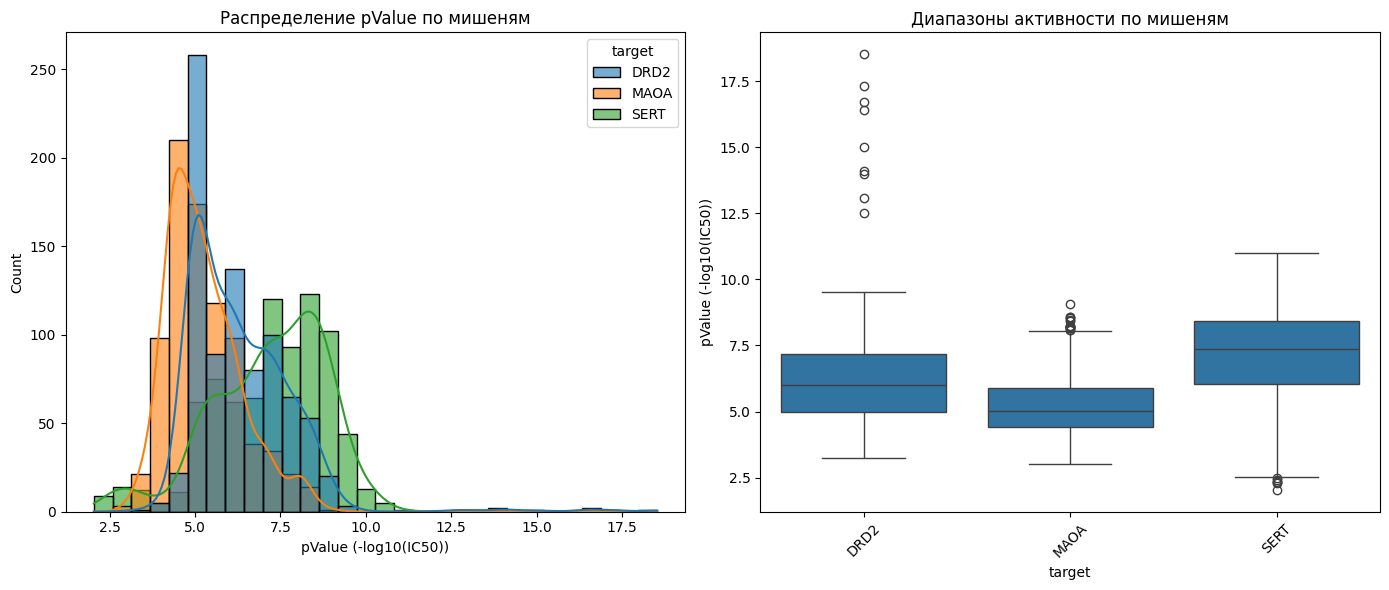


Статистика активности по мишеням:
        count      mean       std       min       25%       50%       75%  \
target                                                                      
DRD2    842.0  6.315759  1.531101  3.236572  5.000000  6.000000  7.192857   
MAOA    830.0  5.241583  1.071562  3.000000  4.423659  5.025950  5.880514   
SERT    815.0  7.174532  1.652932  2.040005  6.055545  7.376751  8.440108   

              max  
target             
DRD2    18.522879  
MAOA     9.080922  
SERT    11.000000  


In [ ]:
def plot_activity_distribution(df):
    """Визуализация распределения активности по мишеням"""
    plt.figure(figsize=(14, 6))

    # Гистограммы pValue по мишеням
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='pValue', hue='target',
                bins=30, kde=True, alpha=0.6)
    plt.title("Распределение pValue по мишеням")
    plt.xlabel("pValue (-log10(IC50))")

    # Boxplot активности по мишеням
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='target', y='pValue')
    plt.title("Диапазоны активности по мишеням")
    plt.ylabel("pValue (-log10(IC50))")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Дополнительная статистика
    print("\nСтатистика активности по мишеням:")
    stats = df.groupby('target')['pValue'].describe()
    print(stats)

# Вызов функции визуализации
if 'combined_df' in locals() and not combined_df.empty:
    plot_activity_distribution(combined_df)
elif final_datasets:
    # Если объединения не было, рисуем для каждого датасета отдельно
    for name, df in final_datasets.items():
        df['target'] = name.split('_')[0]  # Временное добавление target
        plot_activity_distribution(df)
else:
    print("Нет данных для визуализации")

Визуализация первых 2-х компонент

In [ ]:
# Визуализация PCA для каждого датасета и для объединенного датасета
def plot_pca(df, title):
    """Функция для визуализации первых двух PCA компонент"""
    plt.figure(figsize=(10, 8))

    # Проверяем, есть ли необходимые колонки в данных
    if not all(col in df.columns for col in ['PC_1', 'PC_2', 'pValue']):
        print(f"В датасете отсутствуют необходимые колонки для визуализации: {title}")
        return

    # Создаем scatter plot
    scatter = plt.scatter(
        x=df['PC_1'],
        y=df['PC_2'],
        c=df['pValue'],
        cmap='viridis',
        alpha=0.7,
        s=df['pValue']*20  # Размер точек зависит от pValue
    )

    plt.title(f'PCA: Первые две компоненты ({title})', fontsize=14)
    plt.xlabel('PC 1', fontsize=12)
    plt.ylabel('PC 2', fontsize=12)

    # Добавляем цветовую шкалу
    cbar = plt.colorbar(scatter)
    cbar.set_label('pValue', fontsize=12)

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Визуализация PCA компонент...


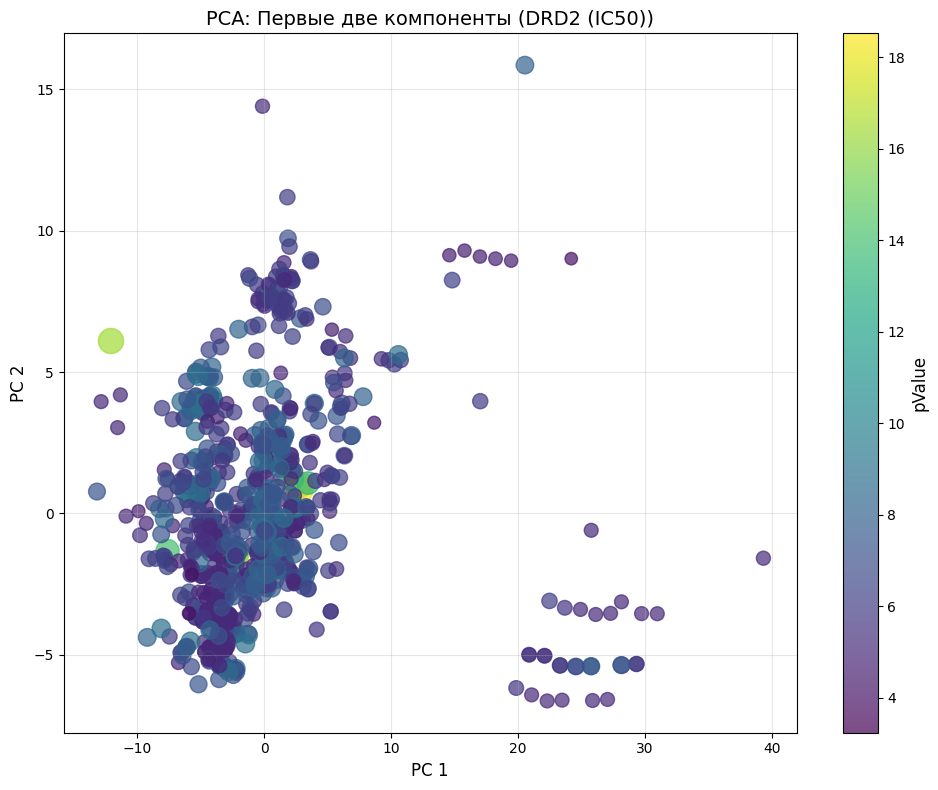

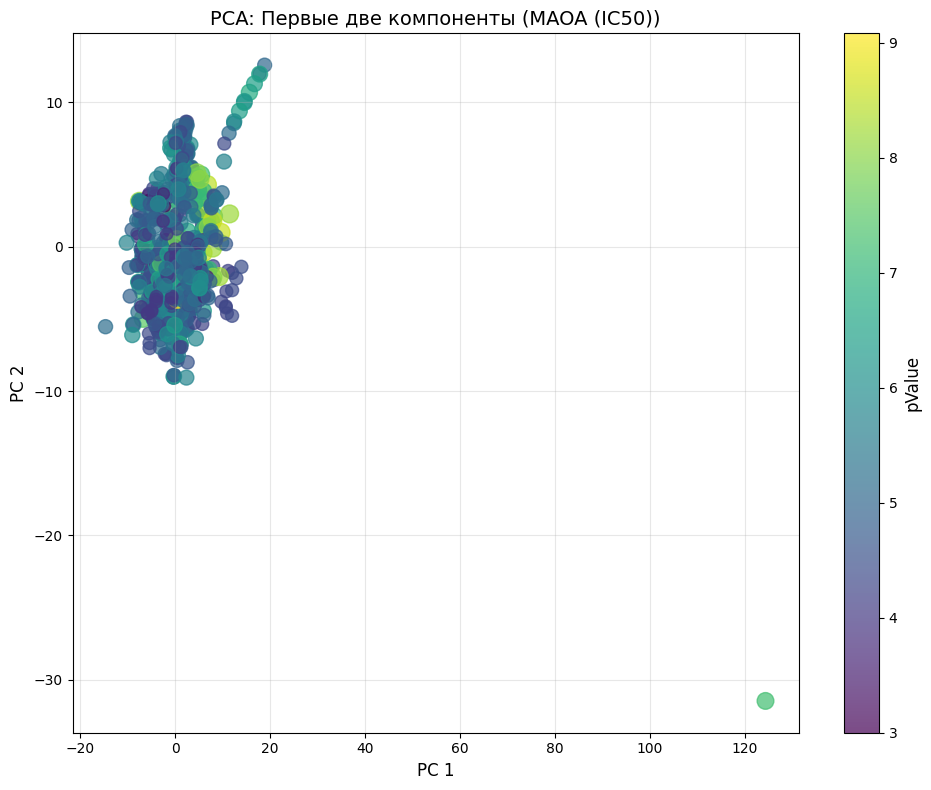

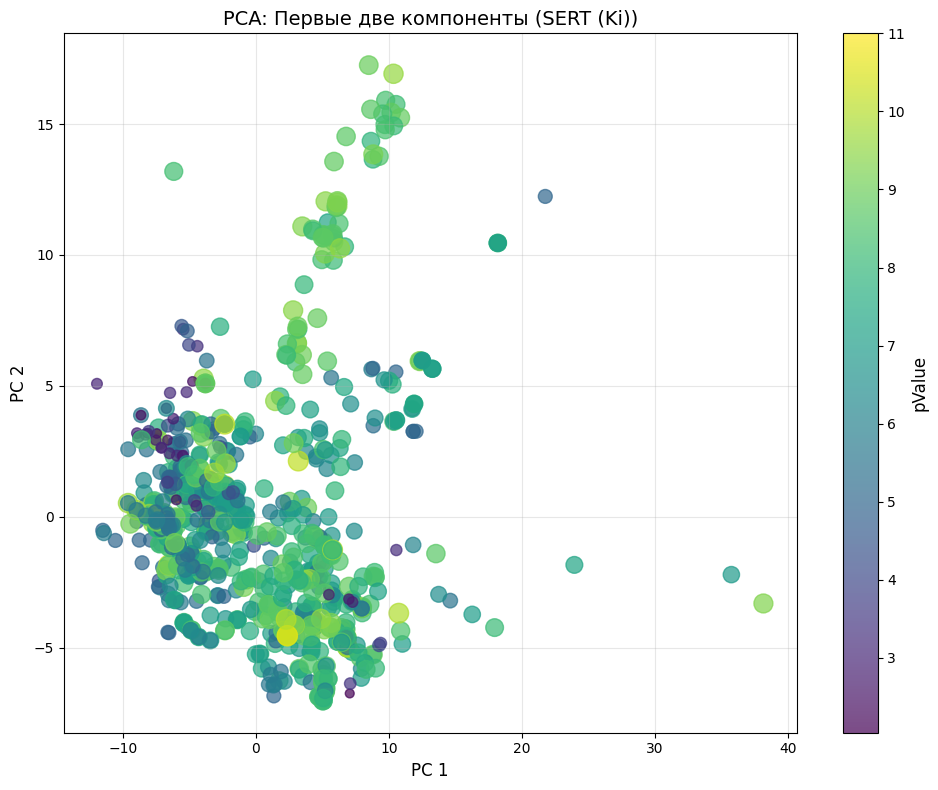

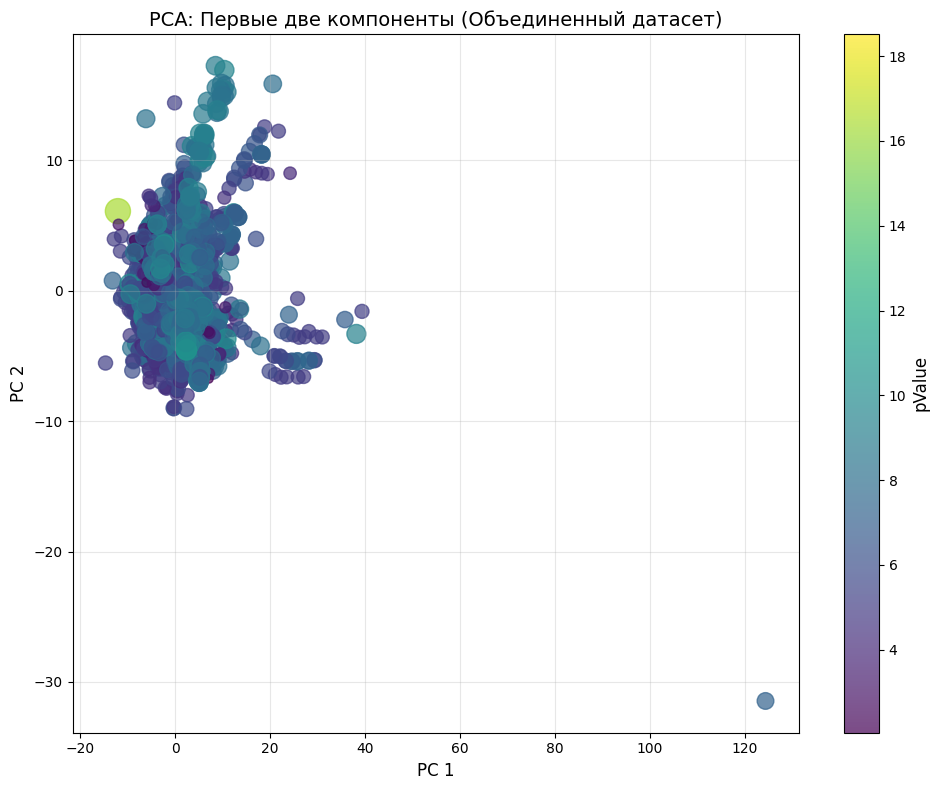

In [ ]:
print("\nВизуализация PCA компонент...")

# Визуализация для каждого отдельного датасета
for dataset_name, df in final_datasets.items():
    target, activity = dataset_name.split('_')
    plot_pca(df, f"{target} ({activity})")

# Визуализация для объединенного датасета (если есть несколько мишеней)
if len(final_datasets) > 1:
    if 'combined_df' in locals():
        plot_pca(combined_df, "Объединенный датасет")
    else:
        print("Объединенный датасет не найден для визуализации")
elif len(final_datasets) == 1:
    print("Только один датасет - объединенная визуализация не требуется")
else:
    print("Нет данных для визуализации PCA")

---

### Этап 3. Обучение модели

---

Обучение и нахождение лучшей модели

---

Модель выбирается на основании того у какой модели лучший показатель R^2 - это описано ниже в программе. При запусках нашей команды получилось, что лучшей была модель CatBoost

---

In [ ]:
def load_and_analyze_data():
    # Загрузка данных
    DATA_PATH = "/content/drive/MyDrive/DataCon2025/all_csv/07_combined/COMBINED_ALL.csv"
    df = pd.read_csv(DATA_PATH)
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Удаление дубликатов
    df = df.drop_duplicates()

    # Анализ данных
    print("Размер датасета:", df.shape)
    print("\nПропуски в данных:")
    print(df.isna().sum().sort_values(ascending=False))

    # Визуализация распределения целевой переменной
    plt.figure(figsize=(12, 6))
    sns.histplot(df['pValue'], kde=True, bins=50)
    plt.title('Распределение pValue')
    plt.show()

    # Удаление служебных колонок
    df = df.drop(columns=['Molecule_ID', 'SMILES'], errors='ignore')
    print("Удалены служебные колонки: MOL, Molecule_ID, SMILES")

    return df

Размер датасета: (2487, 55)

Пропуски в данных:
PC_42            1645
PC_47            1645
PC_46            1645
PC_45            1645
PC_44            1645
PC_43            1645
PC_41            1645
PC_28               0
PC_31               0
PC_30               0
PC_29               0
Molecule_ID         0
PC_27               0
PC_26               0
PC_33               0
PC_25               0
PC_32               0
PC_37               0
PC_34               0
PC_35               0
PC_36               0
PC_23               0
PC_38               0
PC_39               0
PC_40               0
pValue_norm         0
PC_24               0
PC_22               0
SMILES              0
PC_8                0
pValue              0
activity_nM         0
target              0
activity_type       0
PC_1                0
PC_2                0
PC_3                0
PC_4                0
PC_5                0
PC_6                0
PC_7                0
PC_9                0
PC_21               0
PC_10 

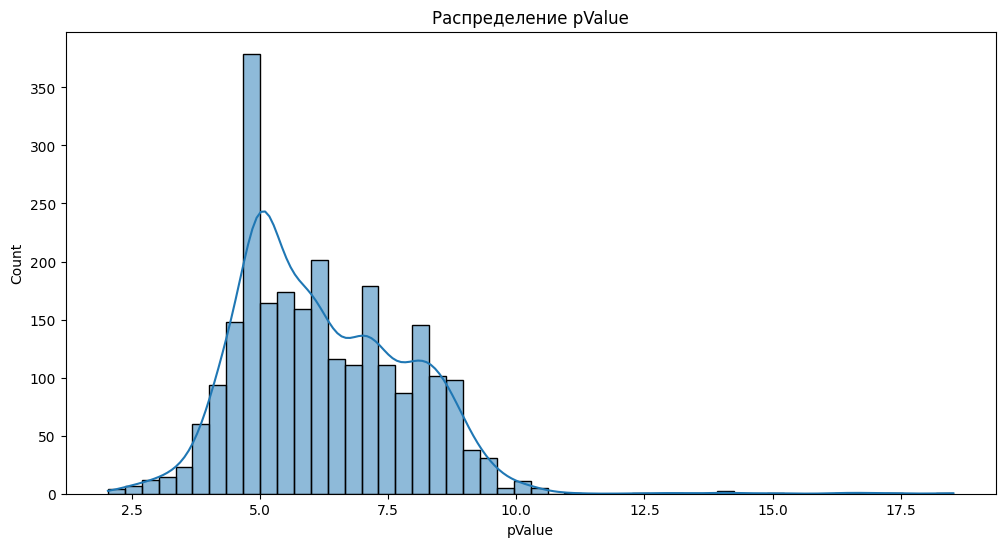

Удалены служебные колонки: MOL, Molecule_ID, SMILES


In [ ]:
df = load_and_analyze_data()

<Axes: xlabel='pValue'>

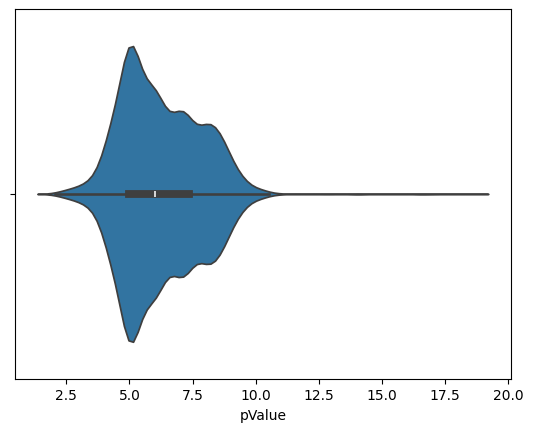

In [ ]:
# Дополнительно, для проверки
sns.violinplot(df, x="pValue")

In [ ]:
def prepare_and_split_data(df):
    """Подготовка данных и разделение на train/test"""
    try:
        print("\nПодготовка данных...")

        # 1. Отделяем целевую переменную и признаки
        X = df.drop(columns=['pValue_norm', 'target', 'activity_type', 'Molecule_ID', 'SMILES'], errors='ignore')
        y = df['pValue_norm'].values

        # 2. Числовые признаки
        numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        X = X[numeric_cols]

        # 3. Обработка пропущенных значений
        imputer = SimpleImputer(strategy='median')
        X_imputed = imputer.fit_transform(X)

        # 4. Отбор признаков
        vt = VarianceThreshold(threshold=0.01)
        X_selected = vt.fit_transform(X_imputed)

        # 5. Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.2, random_state=42
        )

        print("Форма данных:")
        print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
        print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

        return X_train, X_test, y_train, y_test, vt, imputer

    except Exception as e:
        print(f"Ошибка подготовки данных: {str(e)}")
        print("Доступные колонки:", df.columns.tolist())
        raise

In [ ]:
X_train, X_test, y_train, y_test, vt, imputer = prepare_and_split_data(df)


Подготовка данных...
Форма данных:
X_train: (1989, 50), X_test: (498, 50)
y_train: (1989,), y_test: (498,)


In [ ]:
def evaluate_models(X_train, y_train):
    # Настройки кросс-валидации
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    bins = pd.qcut(y_train, q=10, duplicates='drop', labels=False)
    cv_indices = list(cv.split(X_train, bins))

    # Список моделей для сравнения
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(random_state=42)),
        ('Lasso', Lasso(random_state=42)),
        ('RandomForest', RandomForestRegressor(random_state=42, n_jobs=-1)),
        ('XGBoost', XGBRegressor(random_state=42, n_jobs=-1)),
        ('LightGBM', LGBMRegressor(random_state=42, n_jobs=-1)),
        ('CatBoost', CatBoostRegressor(random_state=42, verbose=0)),
        ('KNN', KNeighborsRegressor(n_jobs=-1))
    ]

    # Оценка моделей
    results = []
    for name, model in models:
        # Создаем pipeline с масштабированием для линейных моделей
        if name in ['LinearRegression', 'Ridge', 'Lasso', 'KNN']:
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
        else:
            pipe = Pipeline([('model', model)])

        # Кросс-валидация
        r2_scores = cross_val_score(pipe, X_train, y_train, cv=cv_indices, scoring='r2', n_jobs=-1)
        mae_scores = cross_val_score(pipe, X_train, y_train, cv=cv_indices,
                                   scoring='neg_mean_absolute_error', n_jobs=-1)
        mape_scores = cross_val_score(pipe, X_train, y_train, cv=cv_indices,
                                    scoring='neg_mean_absolute_percentage_error', n_jobs=-1)

        # Сохраняем результаты
        results.append({
            'Model': name,
            'R2_mean': r2_scores.mean(),
            'R2_std': r2_scores.std(),
            'MAE_mean': -mae_scores.mean(),
            'MAE_std': mae_scores.std(),
            'MAPE_mean': -mape_scores.mean(),
            'MAPE_std': mape_scores.std()
        })

    # Результаты в виде DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('R2_mean', ascending=False)

    return results_df

/tmp/ipython-input-27-1400628688.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2_mean', y='Model', data=results_df, palette='viridis')


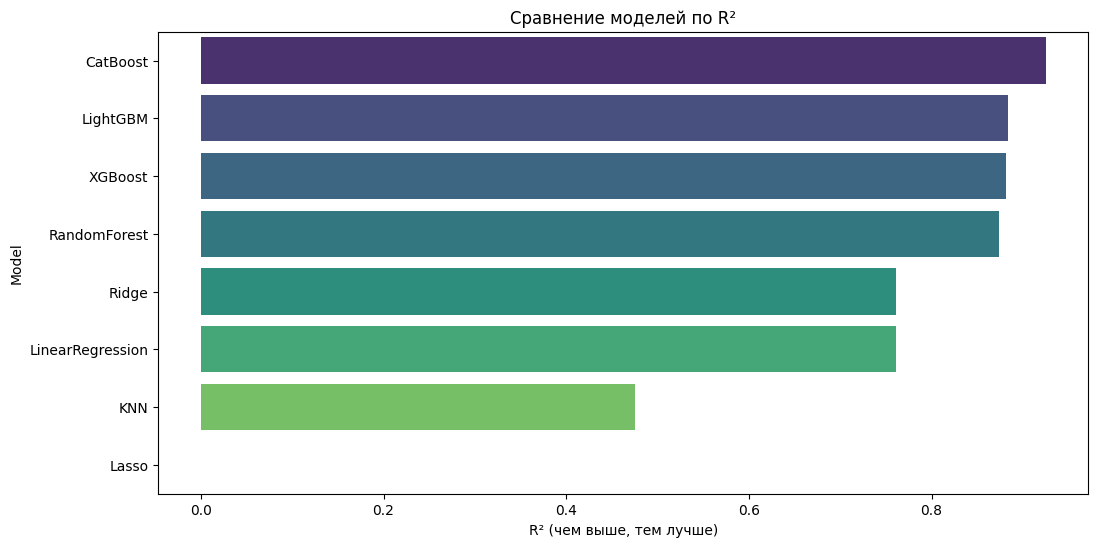


Результаты кросс-валидации:


,Model,R2_mean,R2_std,MAE_mean,MAE_std,MAPE_mean,MAPE_std
6,CatBoost,0.925329,0.008977,0.162651,0.007332,0.957495,0.409323
5,LightGBM,0.883574,0.009041,0.197735,0.005472,0.998724,0.183432
4,XGBoost,0.882013,0.015200,0.204349,0.009604,1.289155,0.647017
3,RandomForest,0.873328,0.023142,0.204553,0.006569,1.349632,0.591729
1,Ridge,0.761321,0.023132,0.371889,0.007994,2.625706,0.777488
0,LinearRegression,0.761319,0.023145,0.371982,0.007980,2.627331,0.778025
7,KNN,0.475758,0.030824,0.484549,0.015903,2.667344,0.965090
2,Lasso,-0.000328,0.000285,0.747664,0.009400,1.121391,0.053365


'\nЭтот кусочек кода нужен, если графики слишком страшные. А так можно и без него.\nГлавное правильно перепишите условие, для того чтобы сделать графики красивее и понятнее.\n\n# Фильтрация моделей по условию R² ≥ -0.5e8\nfiltered_results = results_df[results_df[\'R2_mean\'] >= -0.5e8]\n# Фильтрация добавлена для нормального вывода графика сравнения моделей по R^2\n# Если бы фильтрации не было, то график выглядел бы как 1-ый в выводе этой ячейки\n# С фильтрацией добавляются еще 2 графика, которые лучше показывают сравнение моделей\n\nif not filtered_results.empty:\n    print("\nОтображаем графики для моделей с R² ≥ -0.5e8:")\n\n    # Визуализация результатов\n    plt.figure(figsize=(12, 6))\n    sns.barplot(x=\'R2_mean\', y=\'Model\', data=filtered_results, palette=\'viridis\')\n    plt.title(\'Сравнение моделей по R² (только R² ≥ -0.5e8)\')\n    plt.xlabel(\'R² (чем выше, тем лучше)\')\n    plt.show()\n\n    # Дополнительный график для MAE\n    plt.figure(figsize=(12, 6))\n    sns.bar

In [ ]:
results_df = evaluate_models(X_train, y_train)

# Визуализация результатов
plt.figure(figsize=(12, 6))
sns.barplot(x='R2_mean', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение моделей по R²')
plt.xlabel('R² (чем выше, тем лучше)')
plt.show()

print("\nРезультаты кросс-валидации:")
display(results_df)

Тюнинг лучшей модели (Тюнинг описан не для всех  моделей)

In [ ]:
def tune_best_model(X_train, y_train, results_df):
    if results_df.empty:
        print("Нет результатов для выбора модели")
        return None, None

    # Выбираем лучшую модель
    best_model_name = results_df.iloc[0]['Model']
    print(f"\n{'='*50}")
    print(f"Начинаем тюнинг модели: {best_model_name}")
    print(f"{'='*50}")

    best_params = None
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    bins = pd.qcut(y_train, q=5, duplicates='drop', labels=False)
    cv_indices = list(cv.split(X_train, bins))

    if best_model_name == 'CatBoost':
        def catboost_objective(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 100, 2000),
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
                'depth': trial.suggest_int('depth', 4, 12),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10, log=True),
                'random_strength': trial.suggest_float('random_strength', 0.1, 10),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                'verbose': False,
                'random_state': 42,
                'loss_function': 'MAE'
            }

            model = CatBoostRegressor(**params)
            score = cross_val_score(
                model, X_train, y_train,
                cv=cv_indices, scoring='neg_mean_absolute_error', n_jobs=-1
            ).mean()
            return -score

        study = optuna.create_study(direction='minimize')
        study.optimize(catboost_objective, n_trials=20, timeout=600)
        best_params = study.best_params
        best_model = CatBoostRegressor(**best_params, random_state=42, verbose=0)

    elif best_model_name == 'RandomForest':
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'random_state': 42,
                'n_jobs': -1
            }

            model = RandomForestRegressor(**params)
            score = cross_val_score(
                model, X_train, y_train,
                cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
            ).mean()
            return -score

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=20)
        best_params = study.best_params
        best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

    elif best_model_name == 'LightGBM':
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 20, 200),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'random_state': 42,
                'n_jobs': -1
            }

            model = LGBMRegressor(**params)
            score = cross_val_score(
                model, X_train, y_train,
                cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
            ).mean()
            return -score

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=20)
        best_params = study.best_params
        best_model = LGBMRegressor(**best_params, random_state=42, n_jobs=-1)

    else:
        # Для моделей без тюнинга
        best_params = "Базовые параметры (без тюнинга)"
        print(f"\nИспользуем базовые параметры для {best_model_name}")

        if best_model_name == 'LinearRegression':
            best_model = LinearRegression()
        elif best_model_name == 'Ridge':
            best_model = Ridge(random_state=42)
        elif best_model_name == 'Lasso':
            best_model = Lasso(random_state=42)
        elif best_model_name == 'XGBoost':
            best_model = XGBRegressor(random_state=42, n_jobs=-1)
        elif best_model_name == 'LightGBM':
            best_model = LGBMRegressor(random_state=42, n_jobs=-1)
        elif best_model_name == 'KNN':
            best_model = KNeighborsRegressor(n_jobs=-1)
        else:
            print(f"Модель {best_model_name} не распознана")
            return None, None, None

    # Валидация тюнинга
    print("\nРезультаты после тюнинга:")
    scores = cross_val_score(
        best_model, X_train, y_train,
        cv=cv_indices, scoring='neg_mean_absolute_error', n_jobs=-1
    )
    print(f"MAE: {-scores.mean():.4f} ± {scores.std():.4f}")

    return best_model, best_model_name, best_params

In [ ]:
# После получения results_df из evaluate_models()
results_df = evaluate_models(X_train, y_train)

# Теперь передаем все три аргумента
best_model, best_model_name, best_params = tune_best_model(X_train, y_train, results_df)

# Вывод информации о лучших параметрах
if best_params is not None:
    print("\n" + "="*50)
    print(f"Лучшая модель: {best_model_name}")
    print("Лучшие параметры:")
    if isinstance(best_params, dict):
        for param, value in best_params.items():
            print(f"- {param}: {value}")
    else:
        print(best_params)
    print("="*50)

[I 2025-07-14 22:21:06,039] A new study created in memory with name: no-name-0140d774-5d2b-41f4-a770-d978d0b78a33



Начинаем тюнинг модели: CatBoost


[I 2025-07-14 22:22:17,632] Trial 0 finished with value: 0.37867971220595503 and parameters: {'iterations': 1431, 'learning_rate': 0.0013477845704057709, 'depth': 5, 'l2_leaf_reg': 6.702351648270153, 'random_strength': 1.3676574383728899, 'bagging_temperature': 0.1726931552449621, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.37867971220595503.
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2025-07-14 22:26:34,250] Trial 1 finished with value: 0.3183200040853035 and parameters: {'iterations': 1102, 'learning_rate': 0.004854220471905429, 'depth': 8, 'l2_leaf_reg': 0.13913106234177083, 'random_strength': 9.686281292230849, 'bagging_temperature': 0.4625008707234336, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.3183200040853035.
[I 2025-07-14 22:37:20,200


Результаты после тюнинга:
MAE: 0.3101 ± 0.0157

Лучшая модель: CatBoost
Лучшие параметры:
- iterations: 1102
- learning_rate: 0.004854220471905429
- depth: 8
- l2_leaf_reg: 0.13913106234177083
- random_strength: 9.686281292230849
- bagging_temperature: 0.4625008707234336
- grow_policy: SymmetricTree


In [ ]:
def interpret_model_with_shap(model, X_train, X_test, feature_names, model_name):
    """Интерпретация модели с помощью SHAP-анализа"""
    print("\n" + "="*50)
    print("SHAP-анализ важности признаков")
    print("="*50)

    try:
        shap.initjs()

        # Для линейных моделей используем LinearExplainer
        if model_name in ['LinearRegression', 'Ridge', 'Lasso']:
            explainer = shap.LinearExplainer(model, X_train)
        # Для tree-based моделей - TreeExplainer
        elif model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']:
            explainer = shap.TreeExplainer(model)
        # Для остальных - KernelExplainer
        else:
            explainer = shap.KernelExplainer(model.predict, X_train[:100])

        # Вычисляем SHAP-значения для тестовой выборки
        shap_values = explainer.shap_values(X_test[:100])  # Берем подмножество для скорости

        # Визуализация
        plt.figure(figsize=(16, 12))

        # 1. Важность признаков (глобальная)
        plt.subplot(2,2,1)
        shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, plot_type="bar", show=False)
        plt.title("Глобальная важность признаков")

        # 2. Влияние признаков на предсказание
        plt.subplot(2,2,2)
        shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, show=False)
        plt.title("Влияние признаков на предсказание")

        # Сохранение результатов
        if hasattr(explainer, 'expected_value'):
            print(f"\nБазовое значение (expected value): {explainer.expected_value:.4f}")

        # Создаем DataFrame с важностью признаков
        if isinstance(shap_values, list):
            shap_values = np.array(shap_values)

        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'SHAP_importance': np.abs(shap_values).mean(0)
        }).sort_values('SHAP_importance', ascending=False)

        print("\nТоп-20 важных признаков:")
        print(feature_importance.head(20))

        # Сохранение в файл
        shap_file = "/content/drive/MyDrive/DataCon2025/ML_Best/shap_importance.csv"
        feature_importance.to_csv(shap_file, index=False)
        print(f"\nРезультаты сохранены в: {shap_file}")

    except Exception as e:
        print(f"\nОшибка при выполнении SHAP-анализа: {str(e)}")
        print("Убедитесь, что установлена последняя версия SHAP: pip install shap")


SHAP-анализ важности признаков



Базовое значение (expected value): -0.0428

Топ-20 важных признаков:
       Feature  SHAP_importance
0    Feature_0         0.292421
1    Feature_1         0.250386
2    Feature_2         0.033113
5    Feature_5         0.017176
11  Feature_11         0.016057
6    Feature_6         0.014624
4    Feature_4         0.013784
19  Feature_19         0.013601
22  Feature_22         0.012186
7    Feature_7         0.011463
21  Feature_21         0.009419
28  Feature_28         0.009190
14  Feature_14         0.009045
20  Feature_20         0.008626
13  Feature_13         0.008501
18  Feature_18         0.007488
31  Feature_31         0.007430
9    Feature_9         0.007265
36  Feature_36         0.007108
3    Feature_3         0.007090

Результаты сохранены в: /content/drive/MyDrive/DataCon2025/ML_Best/shap_importance.csv


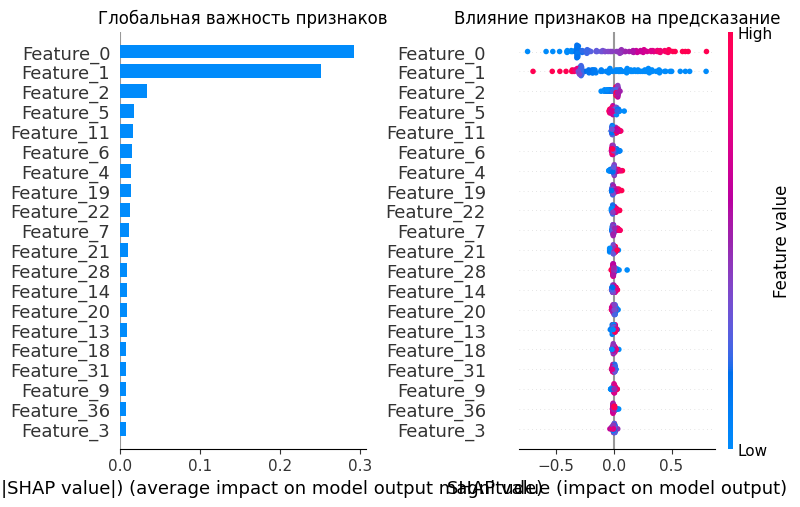

In [ ]:
# Получаем имена признаков после всех преобразований
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

# Вызываем функцию интерпретации
if 'best_model' in locals() and 'best_model_name' in locals():
    interpret_model_with_shap(best_model, X_train, X_test, feature_names, best_model_name)
else:
    print("Модель не найдена для интерпретации")

In [ ]:
def final_evaluation(best_model, X_train, X_test, y_train, y_test, best_model_name):
    # Обучение на всей train выборке
    best_model.fit(X_train, y_train)

    # ====================== Кросс-валидация ======================
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    bins = pd.qcut(y_train, q=10, duplicates='drop', labels=False)
    cv_indices = list(cv.split(X_train, bins))

    # Вычисление метрик на кросс-валидации
    cv_r2 = cross_val_score(best_model, X_train, y_train, cv=cv_indices, scoring='r2')
    cv_mae = cross_val_score(best_model, X_train, y_train, cv=cv_indices,
                           scoring='neg_mean_absolute_error')
    cv_mape = cross_val_score(best_model, X_train, y_train, cv=cv_indices,
                            scoring='neg_mean_absolute_percentage_error')

    # ====================== Тестовая выборка ======================
    y_pred_test = best_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

    # ====================== Красивый вывод метрик ======================
    print("\n" + "="*60)
    print(f"ФИНАЛЬНЫЕ МЕТРИКИ МОДЕЛИ: {best_model_name}")
    print("="*60)

    print("\nКРОСС-ВАЛИДАЦИЯ (5 фолдов):")
    print(f"R²:    {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    print(f"MAE:   {-cv_mae.mean():.4f} ± {cv_mae.std():.4f}")
    print(f"MAPE:  {-cv_mape.mean():.4f} ± {cv_mape.std():.4f}")

    print("\nТЕСТОВАЯ ВЫБОРКА:")
    print(f"R²:    {test_r2:.4f}")
    print(f"MAE:   {test_mae:.4f}")
    print(f"MAPE:  {test_mape:.4f}")
    print("="*60 + "\n")

    # ====================== Визуализация ======================
    plt.figure(figsize=(12, 5))

    # График для кросс-валидации
    plt.subplot(1, 2, 1)
    plt.plot(cv_r2, 'o-', label='R²')
    plt.plot(-np.array(cv_mae), 'o-', label='MAE')
    plt.title('Метрики на кросс-валидации')
    plt.xlabel('Номер фолда')
    plt.ylabel('Значение метрики')
    plt.legend()
    plt.grid(True)

    # График для тестовой выборки
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_test, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title('Предсказания на тестовой выборке')
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказания')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ====================== Сохранение модели и объектов ======================
    # Путь для сохранения
    save_path = "/content/drive/MyDrive/DataCon2025/ML_Best"

    # Создаем папку, если она не существует
    os.makedirs(save_path, exist_ok=True)

    # Сохранение модели и объектов с полными путями
    joblib.dump(best_model, os.path.join(save_path, 'best_model.pkl'))
    joblib.dump(vt, os.path.join(save_path, 'variance_threshold.pkl'))
    joblib.dump(imputer, os.path.join(save_path, 'imputer.pkl'))

    print(f"Модель и объекты успешно сохранены в: {save_path}")

    # Возвращаем все метрики
    return {
        'cv_r2_mean': cv_r2.mean(),
        'cv_r2_std': cv_r2.std(),
        'cv_mae_mean': -cv_mae.mean(),
        'cv_mae_std': cv_mae.std(),
        'cv_mape_mean': -cv_mape.mean(),
        'cv_mape_std': cv_mape.std(),
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mape': test_mape
    }


ФИНАЛЬНЫЕ МЕТРИКИ МОДЕЛИ: CatBoost

КРОСС-ВАЛИДАЦИЯ (5 фолдов):
R²:    0.7817 ± 0.0198
MAE:   0.3114 ± 0.0059
MAPE:  2.0750 ± 0.6822

ТЕСТОВАЯ ВЫБОРКА:
R²:    0.7725
MAE:   0.3187
MAPE:  1.4802



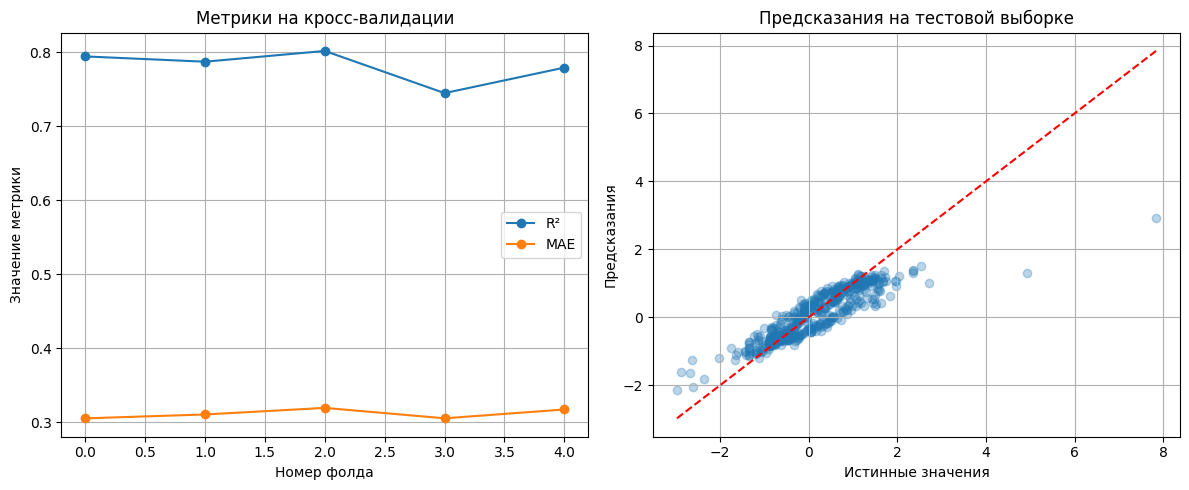

Модель и объекты успешно сохранены в: /content/drive/MyDrive/DataCon2025/ML_Best


In [ ]:
# Продолжаем с финальной оценкой
if best_model is not None:
    final_metrics = final_evaluation(best_model, X_train, X_test, y_train, y_test, best_model_name)

Визуализация структур с высокой/низкой активностью для выявления паттернов

In [ ]:
def visualize_activity_patterns(df, activity_column='pValue', n_examples=5):
    """Визуализация структур с высокой и низкой активностью"""
    print("\n" + "="*50)
    print("Визуализация структур по активности")
    print("="*50)

    try:
        # Проверяем наличие необходимых колонок
        if 'SMILES' not in df.columns or activity_column not in df.columns:
            raise ValueError("Не найдены колонки SMILES или pValue в данных")

        # Удаляем дубликаты SMILES
        df = df.drop_duplicates(subset=['SMILES'])

        # Сортируем молекулы по активности
        df_sorted = df.sort_values(activity_column, ascending=False)

        # Выбираем молекулы с самой высокой и низкой активностью
        high_activity = df_sorted.head(n_examples)
        low_activity = df_sorted.tail(n_examples)

        # Конвертируем SMILES в молекулы
        high_mols = [Chem.MolFromSmiles(s) for s in high_activity['SMILES']]
        low_mols = [Chem.MolFromSmiles(s) for s in low_activity['SMILES']]

        # Удаляем None значения
        high_mols = [m for m in high_mols if m is not None]
        low_mols = [m for m in low_mols if m is not None]

        if not high_mols or not low_mols:
            raise ValueError("Не удалось конвертировать SMILES в молекулы")

        # 1. Визуализация молекул с высокой активностью
        print(f"\nТоп-{len(high_mols)} молекул с высокой активностью:")
        img = Draw.MolsToGridImage(high_mols,
                                 legends=[f"{activity_column}={row[activity_column]:.2f}"
                                         for _, row in high_activity.iterrows()],
                                 molsPerRow=min(3, len(high_mols)),
                                 subImgSize=(300, 300))
        display(img)

        # 2. Визуализация молекул с низкой активностью
        print(f"\nТоп-{len(low_mols)} молекул с низкой активностью:")
        img = Draw.MolsToGridImage(low_mols,
                                 legends=[f"{activity_column}={row[activity_column]:.2f}"
                                         for _, row in low_activity.iterrows()],
                                 molsPerRow=min(3, len(low_mols)),
                                 subImgSize=(300, 300))
        display(img)

        # 3. Анализ общих фрагментов в высокоактивных молекулах
        print("\nАнализ общих структурных особенностей:")
        analyze_common_features(high_mols, activity_type="high")
        analyze_common_features(low_mols, activity_type="low")

        # Сохранение изображений
        save_mol_images(high_mols, high_activity[activity_column], "/content/drive/MyDrive/DataCon2025/visualization/high_activity")
        save_mol_images(low_mols, low_activity[activity_column], "/content/drive/MyDrive/DataCon2025/visualization/low_activity")

    except Exception as e:
        print(f"Ошибка при визуализации структур: {str(e)}")

In [ ]:
def analyze_common_features(mols, activity_type="high"):
    """Анализ общих структурных особенностей"""

    if len(mols) < 2:
        print(f"Недостаточно молекул ({len(mols)}) для анализа общих особенностей ({activity_type} activity)")
        return

    # Находим максимальные общие подструктуры
    mcs = rdFMCS.FindMCS(mols, timeout=60)
    print(f"\nОбщие структурные особенности ({activity_type} activity):")
    print(f"  - Наибольшая общая подструктура: {mcs.smartsString}")
    print(f"  - Размер: {mcs.numAtoms} атомов, {mcs.numBonds} связей")
    print(f"  - Встречается в {mcs.numMatches} из {len(mols)} молекул")

    # Визуализация MCS
    if mcs.smartsString:
        mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
        if mcs_mol:
            img = Draw.MolToImage(mcs_mol, size=(300, 300))
            display(img)

            # Подсчет частоты атомов в MCS
            atom_counts = Counter(atom.GetSymbol() for atom in mcs_mol.GetAtoms())
            print("\nСостав MCS:")
            for atom, count in atom_counts.items():
                print(f"  - {atom}: {count}")

In [ ]:
def save_mol_images(mols, activities, save_dir):
    """Сохранение изображений молекул"""
    os.makedirs(save_dir, exist_ok=True)

    for i, (mol, activity) in enumerate(zip(mols, activities)):
        try:
            img = Draw.MolToImage(mol, size=(400, 400))
            img.save(f"{save_dir}/mol_{i}_activity_{activity:.2f}.png")
        except Exception as e:
            print(f"Ошибка при сохранении молекулы {i}: {str(e)}")

    print(f"Изображения сохранены в: {save_dir}")


Визуализация структур по активности

Топ-10 молекул с высокой активностью:


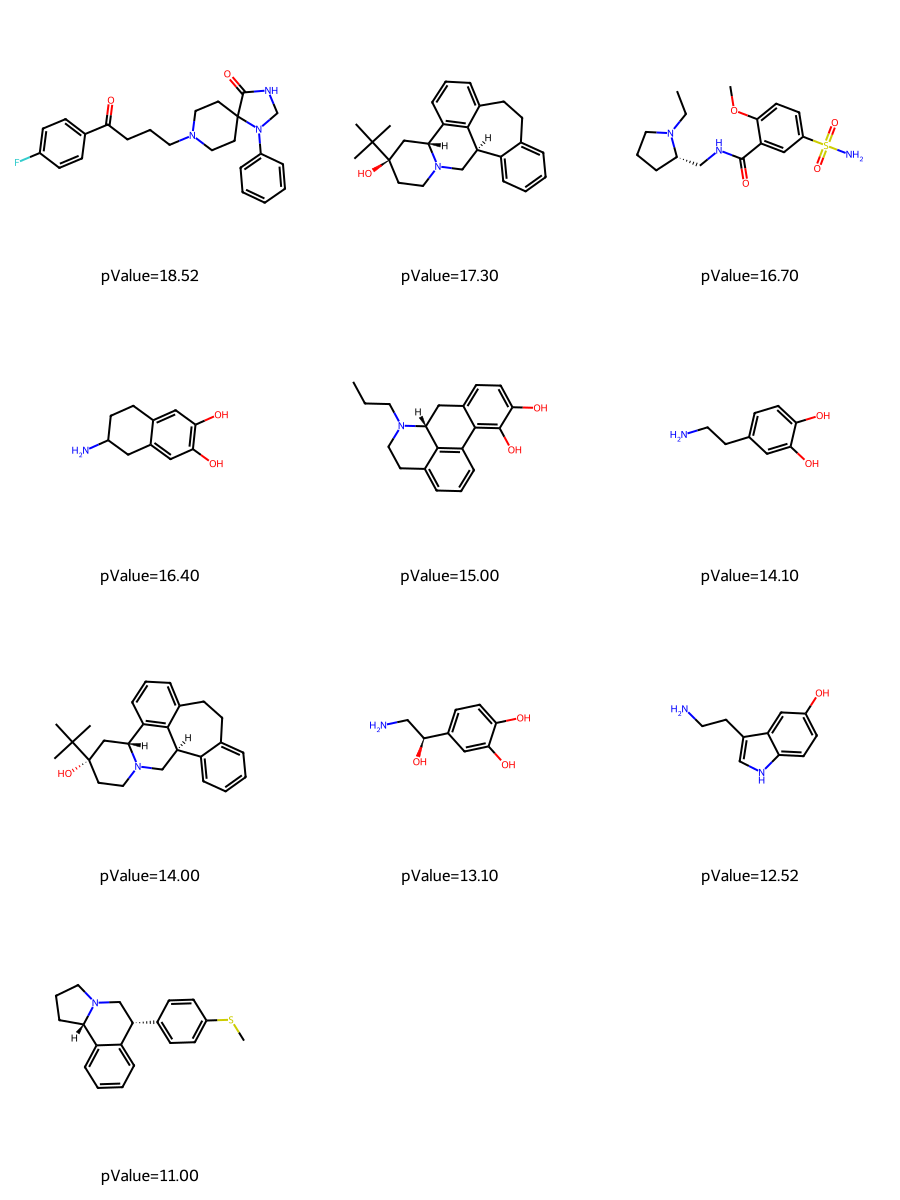


Топ-10 молекул с низкой активностью:


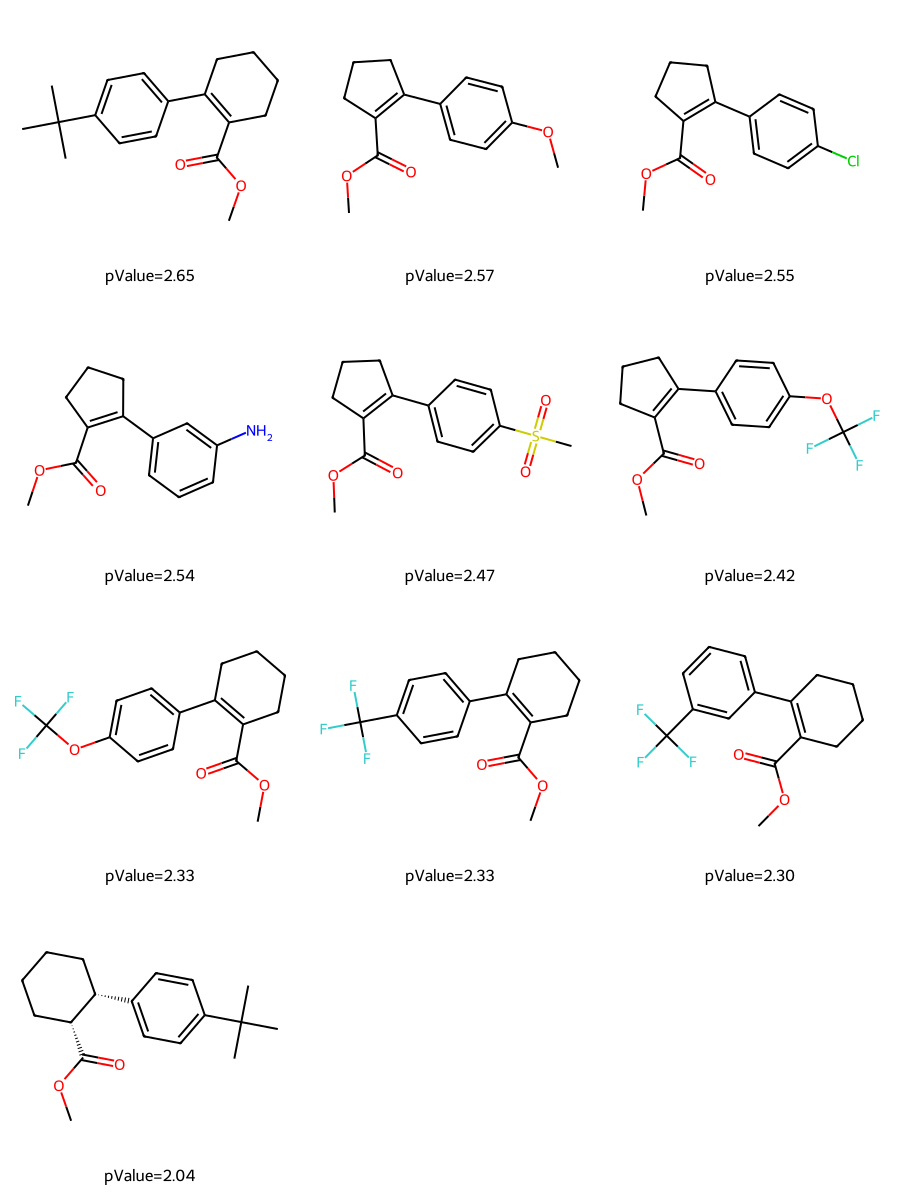


Анализ общих структурных особенностей:

Общие структурные особенности (high activity):
  - Наибольшая общая подструктура: [#7]-[#6]-[#6]-,:[#6]:,-[#6]:,-[#6]:,-[#6]:[#6]
  - Размер: 8 атомов, 7 связей
Ошибка при визуализации структур: 'MCSResult' object has no attribute 'numMatches'


In [ ]:
# Вызываем функцию визуализации
if 'combined_df' in locals() and not combined_df.empty:
    visualize_activity_patterns(combined_df, activity_column='pValue', n_examples=10)
elif 'final_datasets' in locals() and final_datasets:
    for name, df in final_datasets.items():
        print(f"\nАнализ для датасета: {name}")
        visualize_activity_patterns(df, activity_column='pValue', n_examples=5)
else:
    print("Нет данных для визуализации структур")

---

### Этап 4. Генерация молекул

---

Подключаем нейросеть

In [ ]:
%%bash
pip uninstall -y torch torchvision torchaudio

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124


ВАЖНО! На этоп этапе делаем следующее:

Среда выполнения -> Перезапустить сеанс

После этого выполнять блоки кода ниже

In [ ]:
%%bash
pip install --upgrade git+https://github.com/MolecularAI/REINVENT4.git@main

  Cloning https://github.com/MolecularAI/REINVENT4.git (to revision main) to /tmp/pip-req-build-wvlom68h
  Resolved https://github.com/MolecularAI/REINVENT4.git to commit 3266e54bbe148831796477577d977de8cfbdeb05
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/166.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
INFO: pip is 

  Running command git clone --filter=blob:none --quiet https://github.com/MolecularAI/REINVENT4.git /tmp/pip-req-build-wvlom68h
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
%%bash
# 1) Клонируем репозиторий, чтобы получить priors/
rm -rf /content/REINVENT4_repo    # Добавили для очистки, для случая повторной загрузки, чтобы не возникало ошибок
git clone https://github.com/MolecularAI/REINVENT4.git /content/REINVENT4_repo

# 2) Создаём папку для результатов
mkdir -p /content/drive/MyDrive/DataCon2025/nn/output

# 3) Пишем agent.toml
cat > /content/drive/MyDrive/DataCon2025/nn/agent.toml << 'EOF'
run_type        = "sampling"
device          = "cpu"     # или "cuda:0", зависит от того, что вы используете
json_out_config = "_agent.json"

[parameters]
model_file       = "/content/REINVENT4_repo/priors/reinvent.prior"
output_file      = "/content/drive/MyDrive/DataCon2025/nn/output/sampling.csv"
num_smiles       = 5000
unique_molecules = true
randomize_smiles = true
EOF

Cloning into '/content/REINVENT4_repo'...
Updating files: 100% (562/562), done.


In [ ]:
%%bash
reinvent -l /content/drive/MyDrive/DataCon2025/nn/output/agent.log \
         /content/drive/MyDrive/DataCon2025/nn/agent.toml

2025-07-14 23:26:39.955665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752535599.981261   25680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752535599.988490   25680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 23:26:40.013050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

### Этап 5. Отбор кандидатов

---

In [ ]:
!pip install --upgrade numpy

ВАЖНО! На этоп этапе делаем следующее:

Среда выполнения -> Перезапустить сеанс

P.S. Это делается из-за несовместимости версий Numpy + установки CatBoost

In [ ]:
import joblib
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Descriptors, Lipinski
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import numpy as np
from collections import Counter

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.


In [ ]:
# 1. Загрузка данных
df = pd.read_csv('/content/drive/MyDrive/DataCon2025/nn/output/sampling.csv')
print(f"Всего молекул: {len(df)}")

Всего молекул: 4918


In [ ]:
# 2. Функции для расчета свойств
def is_valid_smiles(smiles):
    """Проверка валидности SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

In [ ]:
def calculate_sa_score(mol):
    """Оценка синтезируемости (упрощенная версия)"""
    if not mol:
        return 10  # Худший возможный результат

    # Эмпирическая формула на основе молекулярного веса и количества колец
    mw = Descriptors.MolWt(mol)
    rings = Chem.GetSSSR(mol)
    score = 0.5 * (mw / 100) + len(rings)
    return min(10, max(1, score))  # Ограничиваем диапазон 1-10

In [ ]:
def predict_bbb(mol):
    """Прогноз проходимости через ГЭБ (эмпирические правила)"""
    if not mol:
        return 0

    # Правило: MW < 450 и LogP < 3 и PSA < 90
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    psa = Descriptors.TPSA(mol)

    return int(mw < 450 and logp < 3 and psa < 90)

In [ ]:
def has_toxicophores(mol):
    """Проверка на токсичность"""
    if not mol:
        return 1

    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
    catalog = FilterCatalog(params)
    return int(catalog.HasMatch(mol))

In [ ]:
def lipinski_violations(mol):
    """Кол-во нарушений правил Липинского"""
    if not mol:
        return 5

    violations = 0
    # Правила: MW <= 500, LogP <= 5, HBD <= 5, HBA <= 10
    if Descriptors.MolWt(mol) > 500: violations += 1
    if Descriptors.MolLogP(mol) > 5: violations += 1
    if Lipinski.NumHDonors(mol) > 5: violations += 1
    if Lipinski.NumHAcceptors(mol) > 10: violations += 1
    return violations

In [ ]:
# Загружаем модель
model_path = '/content/drive/MyDrive/DataCon2025/ML_Best/best_model.pkl'
model = joblib.load(model_path)

In [ ]:
def predict_pvalue(smiles):
    """Функция для предсказания pValue"""
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return 0.0

    # Генерация фичей
    fp = Chem.RDKFingerprint(mol)
    X = np.array(fp).reshape(1, -1)

    return model.predict(X)[0]

In [ ]:
# 3. Обработка молекул
results = []
for smiles in df['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        continue  # Пропускаем невалидные молекулы

    # Вычисляем все свойства
    pvalue = predict_pvalue(smiles)
    qed = QED.qed(mol)
    sa_score = calculate_sa_score(mol)
    bbb = predict_bbb(mol)
    toxic = has_toxicophores(mol)
    lipinski = lipinski_violations(mol)

    # Проверяем критерии отбора
    is_hit = (
        pvalue > 6.0 and
        qed > 0.5 and
        2 < sa_score < 6 and
        bbb == 1 and
        toxic == 0 and
        lipinski <= 1
    )

    # Формируем комментарий
    comment = "Hit" if is_hit else "Not hit"

    results.append({
        'SMILES': smiles,
        'pValue': round(pvalue, 2),
        'QED': round(qed, 2),
        'SA_Score': round(sa_score, 2),
        'BBB': bbb,
        'Toxicophore': toxic,
        'Lipinski_violations': lipinski,
        'Status': comment
    })

In [ ]:
# 4. Сохранение результатов
result_df = pd.DataFrame(results)
print(f"\nВалидных молекул: {len(result_df)}")
print(f"Хитов: {sum(result_df['Status'] == 'Hit')}")

# Сохраняем все молекулы с аннотацией
result_df.to_csv('/content/drive/MyDrive/DataCon2025/nn/output/annotated_molecules.csv', index=False)

# Сохраняем только хиты
hits_df = result_df[result_df['Status'] == 'Hit']
hits_df.to_csv('/content/drive/MyDrive/DataCon2025/nn/output/selected_hits.csv', index=False)

print("\nГотово! Результаты сохранены в:")
print("- annotated_molecules.csv (все аннотированные молекулы)")
print("- selected_hits.csv (только хиты)")


Валидных молекул: 4918
Хитов: 0

Готово! Результаты сохранены в:
- annotated_molecules.csv (все аннотированные молекулы)
- selected_hits.csv (только хиты)


Молекулярный докинг

In [ ]:
# К сожалению, с докингом не получилось

Визуализация топ-хитов